In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC #LinearSVC should scale better to a higher number of samples than SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, SpatialDropout1D, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Bidirectional,GRU,Input, Dense, Activation, RepeatVector, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print("Error: ",e)
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from transformers import BertTokenizer, TFBertModel
from transformers import RobertaTokenizer, TFRobertaModel
from transformers import XLNetTokenizer, TFXLNetModel

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_confusion_matrix

from scipy.stats import pearsonr

import joblib

import numpy as np
import pickle

pd.set_option('display.max_colwidth', 50)


In [2]:
def check(df):
    l=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(l)
    df_check.columns=['column','dtypes','nunique','sum_null']
    return df_check 

In [3]:
def plot_train_val_loss_acc(history):
    # plot learning curves
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # plot validation curves
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [4]:
# Load data from CSV file
import pandas as pd
df = pd.read_csv('Final_preprocessed_dataset_portuguese.csv')#.sample(10000).reset_index(drop='index')
df.head()

,Text,Source,URL,Label,text_preprocessed,count_words_text,num_nouns_text,num_verbs_text,num_adj_text,num_adv_text,sentiment_avg_text,features
0,PJ em operação internacional de tráfico de dro...,DN,https://www.dn.pt/sociedade/pj-em-operacao-int...,1,PJ operação internacional tráfico droga apreen...,206,42,28,15,5,-0.7351,PJ operação internacional tráfico droga apreen...
1,O texto foi criado - numa universidade da Repú...,NaN,https://poligrafo.sapo.pt/fact-check/fact-chec...,1,texto criar - universidade República Checa - s...,130,40,22,13,1,0.0000,texto criar - universidade República Checa - s...
2,Nunca pague multas por conduzir sem carta ou s...,Contas Poupança,https://arquivo.pt/wayback/20200626170105mp_/h...,0,nunca paguar multa conduzir carta Cartão Cidad...,306,81,69,32,19,0.1677,nunca paguar multa conduzir carta Cartão Cidad...
3,"Depois de António Guterres, uma estátua de D. ...",redes sociais,https://poligrafo.sapo.pt/fact-check/fact-chec...,0,"António Guterres , estátua D. Afonso Henriques...",164,29,21,11,3,0.0000,"António Guterres , estátua D. Afonso Henriques..."
4,"O MAR, uma droga gratuita que cura pelo menos ...",Coruja,https://arquivo.pt/wayback/20181012145922mp_/h...,0,"MAR , droga gratuito cura menos 16 DOENÇAS ! F...",538,191,66,105,24,0.5093,"MAR , droga gratuito cura menos 16 DOENÇAS ! F..."


Concatenate and scale x_train

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Text'])

# Convert text to sequences
x_text_sequences = tokenizer.texts_to_sequences(df['text_preprocessed'])

# Pad sequences to a fixed length (adjust maxlen as needed)
maxlen = 512
x_text_padded = pad_sequences(x_text_sequences, maxlen=maxlen, padding='post')

# Combine all features into one array
x_word_count = df['count_words_text'].values.reshape(-1, 1)
x_nouns_count = df['num_nouns_text'].values.reshape(-1, 1)
x_verbs_count = df['num_verbs_text'].values.reshape(-1, 1)
x_adj_count = df['num_adj_text'].values.reshape(-1, 1)
x_adv_count = df['num_adv_text'].values.reshape(-1, 1)
x_sentiment_avg = df['sentiment_avg_text'].values.reshape(-1, 1)

In [6]:
x_combined = np.concatenate([x_text_padded, x_word_count, x_nouns_count, x_verbs_count, x_adj_count, x_adv_count, x_sentiment_avg], axis=1)

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_combined, df['Label'], test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

DNN

Epoch 1/20
317/317 [==============================] - 2s 7ms/step - loss: 1.3217 - accuracy: 0.6457 - val_loss: 0.7020 - val_accuracy: 0.6795
Epoch 2/20
317/317 [==============================] - 2s 6ms/step - loss: 0.6949 - accuracy: 0.6791 - val_loss: 0.6789 - val_accuracy: 0.6861
Epoch 3/20
317/317 [==============================] - 2s 7ms/step - loss: 0.6818 - accuracy: 0.6884 - val_loss: 0.6793 - val_accuracy: 0.6839
Epoch 4/20
317/317 [==============================] - 2s 6ms/step - loss: 0.6724 - accuracy: 0.6945 - val_loss: 0.6690 - val_accuracy: 0.6906
Epoch 5/20
317/317 [==============================] - 2s 6ms/step - loss: 0.6654 - accuracy: 0.7040 - val_loss: 0.6615 - val_accuracy: 0.7081
Epoch 6/20
317/317 [==============================] - 2s 7ms/step - loss: 0.6597 - accuracy: 0.7080 - val_loss: 0.6662 - val_accuracy: 0.7144
Epoch 7/20
317/317 [==============================] - 2s 7ms/step - loss: 0.6500 - accuracy: 0.7152 - val_loss: 0.6613 - val_accuracy: 0.7184
Epoch 

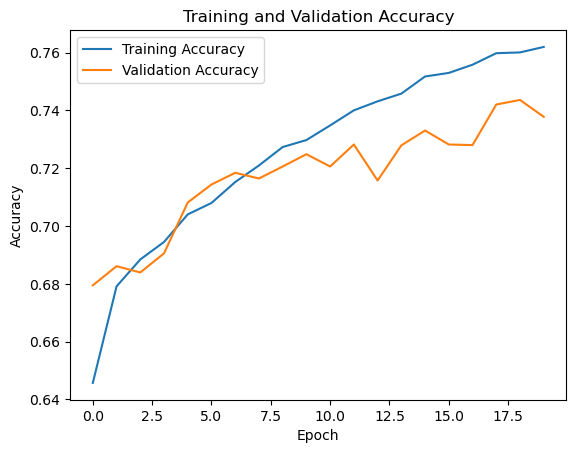

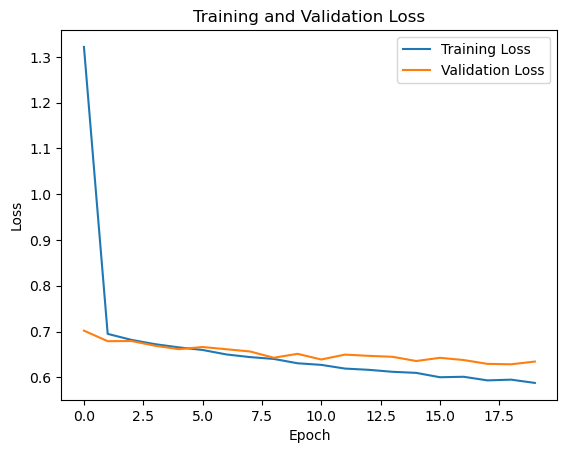

In [33]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=x_train_scaled.shape[1], kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_scaled,
                    y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(x_test_scaled, y_test),
                    validation_split = 0.2,
                    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

# evaluate the model
test_loss, test_acc = model.evaluate(x=x_test_scaled, y=y_test, batch_size=128)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

plot_train_val_loss_acc(history)

# train_sizes, train_scores, test_scores = learning_curve(model, x_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))

# train_scores_mean = np.mean(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)

# plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
# plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

# plt.xlabel('Training examples')
# plt.ylabel('Score')
# plt.legend(loc='best')
# plt.show()

In [35]:
# Assuming your model is named 'model' and you have 'X_test' for test data
y_pred_test = model.predict(x_test_scaled)

# Convert continuous predictions to binary using a threshold (e.g., 0.5)
threshold = 0.5
y_pred_binary = (y_pred_test >= threshold).astype(int)

# Calculate and print the classification report
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      6285
           1       0.76      0.68      0.72      6363

    accuracy                           0.73     12648
   macro avg       0.73      0.73      0.73     12648
weighted avg       0.73      0.73      0.73     12648



CNN

Epoch 1/50
633/633 [==============================] - 16s 25ms/step - loss: 0.6619 - accuracy: 0.6117 - val_loss: 0.6387 - val_accuracy: 0.6395
Epoch 2/50
633/633 [==============================] - 14s 22ms/step - loss: 0.6290 - accuracy: 0.6470 - val_loss: 0.5991 - val_accuracy: 0.6762
Epoch 3/50
633/633 [==============================] - 15s 24ms/step - loss: 0.5899 - accuracy: 0.6835 - val_loss: 0.5579 - val_accuracy: 0.7139
Epoch 4/50
633/633 [==============================] - 15s 23ms/step - loss: 0.5579 - accuracy: 0.7107 - val_loss: 0.5390 - val_accuracy: 0.7287
Epoch 5/50
633/633 [==============================] - 15s 23ms/step - loss: 0.5361 - accuracy: 0.7248 - val_loss: 0.5173 - val_accuracy: 0.7409
Epoch 6/50
633/633 [==============================] - 16s 25ms/step - loss: 0.5230 - accuracy: 0.7357 - val_loss: 0.5085 - val_accuracy: 0.7387
Epoch 7/50
633/633 [==============================] - 16s 25ms/step - loss: 0.5147 - accuracy: 0.7379 - val_loss: 0.5070 - val_accuracy:

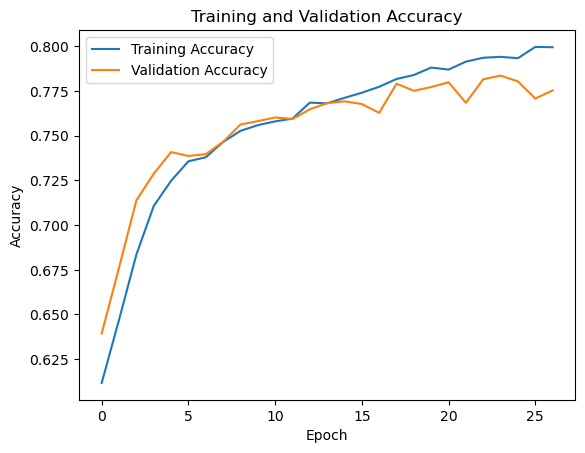

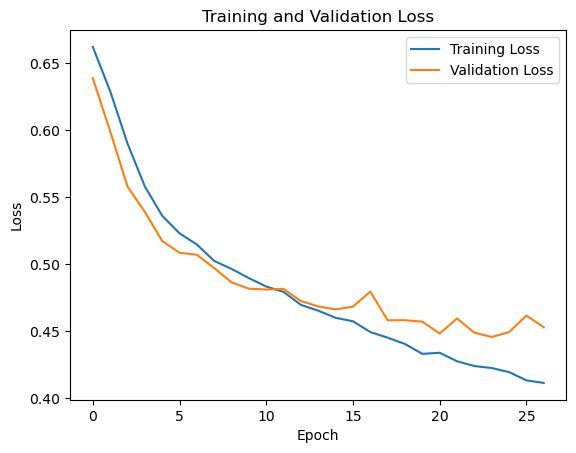

In [11]:
# reshape data for CNN input
x_train_reshaped = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
x_test_reshaped = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_reshaped,
                    y_train,
                    epochs=50,
                    batch_size=64,
                    validation_data=(x_test_reshaped, y_test),
                    validation_split = 0.2,
                    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

# evaluate the model
loss, accuracy = model.evaluate(x_test_reshaped, y_test, batch_size=64)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

plot_train_val_loss_acc(history)

In [13]:
# Reshape the test data to add the sequence length dimension
X_test_reshaped_pred = np.expand_dims(x_test_scaled, axis=2)

# Make predictions on the reshaped test data
y_pred_test = model.predict(X_test_reshaped_pred)

# Convert continuous predictions to binary using a threshold (e.g., 0.5)
threshold = 0.5
y_pred_binary = (y_pred_test >= threshold).astype(int)

# Calculate and print the classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.77      0.80      0.78      6285
           1       0.79      0.76      0.78      6363

    accuracy                           0.78     12648
   macro avg       0.78      0.78      0.78     12648
weighted avg       0.78      0.78      0.78     12648



RNN (takes too long, not viable)

Epoch 1/10
396/396 [==============================] - 287s 723ms/step - loss: 0.6096 - accuracy: 0.6792 - val_loss: 0.5908 - val_accuracy: 0.6913
Epoch 2/10
396/396 [==============================] - 286s 723ms/step - loss: 0.5914 - accuracy: 0.6887 - val_loss: 0.5849 - val_accuracy: 0.6953
Epoch 3/10
396/396 [==============================] - 283s 716ms/step - loss: 0.5921 - accuracy: 0.6862 - val_loss: 0.5862 - val_accuracy: 0.6899
Epoch 4/10
396/396 [==============================] - 293s 740ms/step - loss: 0.5848 - accuracy: 0.6913 - val_loss: 0.5839 - val_accuracy: 0.6998
Epoch 5/10
396/396 [==============================] - 286s 722ms/step - loss: 0.5850 - accuracy: 0.6919 - val_loss: 0.5864 - val_accuracy: 0.6966
Epoch 6/10
396/396 [==============================] - 282s 712ms/step - loss: 0.5841 - accuracy: 0.6946 - val_loss: 0.5811 - val_accuracy: 0.6947
Epoch 7/10
198/198 [==============================] - 23s 114ms/step - loss: 0.5839 - accuracy: 0.6998
Test loss: 0.584, Tes

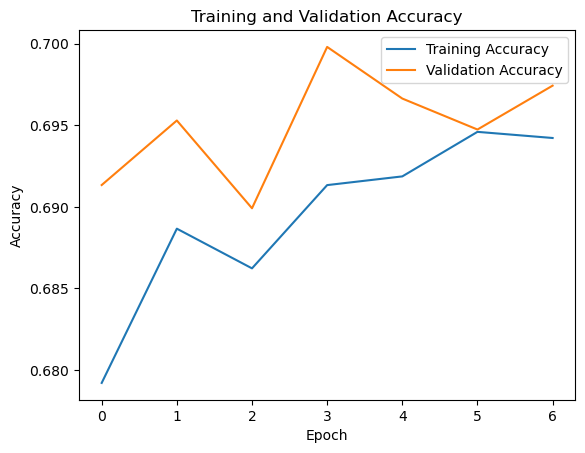

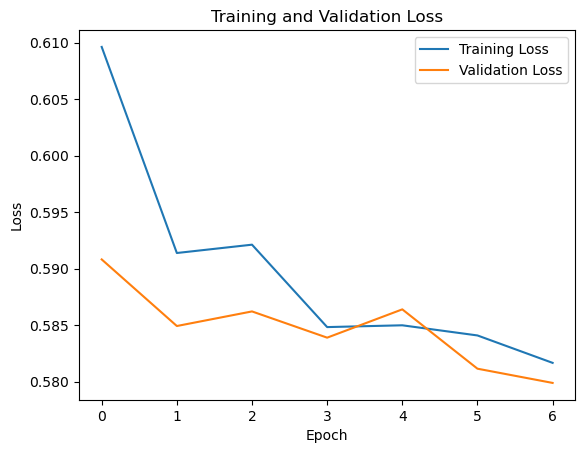

In [16]:
# # reshape the input data for RNN
x_train_reshaped = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
x_test_reshaped = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

# define the model
model = Sequential()
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit the model and track the history
history = model.fit(x_train_reshaped,
                    y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(x_test_reshaped, y_test),
                    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

# evaluate the model
loss, accuracy = model.evaluate(x_test_reshaped, y_test, batch_size=64)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

plot_train_val_loss_acc(history)

LSTM

Epoch 1/20
317/317 [==============================] - 16s 49ms/step - loss: 0.6584 - accuracy: 0.6132 - val_loss: 0.6427 - val_accuracy: 0.6326
Epoch 2/20
317/317 [==============================] - 16s 49ms/step - loss: 0.6393 - accuracy: 0.6353 - val_loss: 0.6245 - val_accuracy: 0.6506
Epoch 3/20
317/317 [==============================] - 15s 47ms/step - loss: 0.6202 - accuracy: 0.6565 - val_loss: 0.6073 - val_accuracy: 0.6745
Epoch 4/20
317/317 [==============================] - 15s 48ms/step - loss: 0.6087 - accuracy: 0.6665 - val_loss: 0.6023 - val_accuracy: 0.6737
Epoch 5/20
317/317 [==============================] - 15s 48ms/step - loss: 0.6040 - accuracy: 0.6723 - val_loss: 0.6013 - val_accuracy: 0.6731
Epoch 6/20
317/317 [==============================] - 16s 49ms/step - loss: 0.6005 - accuracy: 0.6748 - val_loss: 0.5922 - val_accuracy: 0.6835
Epoch 7/20
317/317 [==============================] - 15s 48ms/step - loss: 0.5981 - accuracy: 0.6746 - val_loss: 0.5919 - val_accuracy:

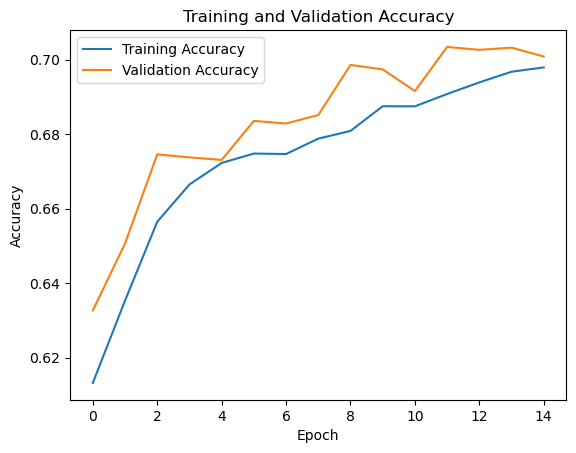

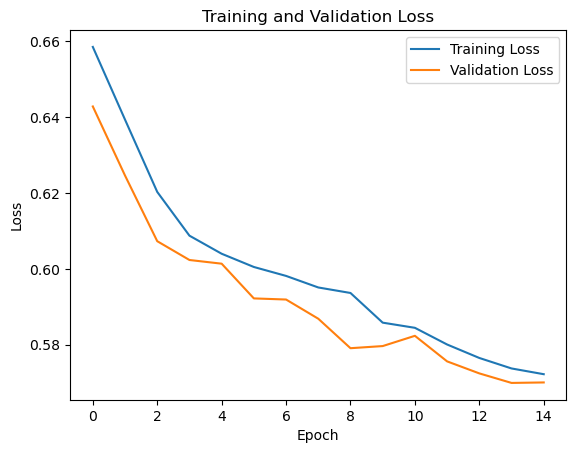

In [20]:
# reshape the input data for LSTM
# x_train_reshaped = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
# x_test_reshaped = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

# define the model
model = Sequential()
model.add(LSTM(64, input_shape=(x_train_reshaped.shape[1],  1)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit the model and track the history
history = model.fit(x_train_reshaped,
                    y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(x_test_reshaped, y_test),
                    validation_split = 0.2,
                    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])
#callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)]

# evaluate the model
loss, accuracy = model.evaluate(x_test_reshaped, y_test, batch_size=128)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

plot_train_val_loss_acc(history)

In [23]:
# Reshape the test data to add the sequence length dimension
#X_test_reshaped_pred = np.expand_dims(x_test_reshaped, axis=2)

# Make predictions on the reshaped test data
y_pred_test = model.predict(x_test_reshaped)

# Convert continuous predictions to binary using a threshold (e.g., 0.5)
threshold = 0.5
y_pred_binary = (y_pred_test >= threshold).astype(int)

# Calculate and print the classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.68      0.73      0.70      6285
           1       0.71      0.66      0.68      6363

    accuracy                           0.69     12648
   macro avg       0.70      0.69      0.69     12648
weighted avg       0.70      0.69      0.69     12648



Bi-LSTM

Epoch 1/20
317/317 [==============================] - 39s 117ms/step - loss: 0.6586 - accuracy: 0.6187 - val_loss: 0.6387 - val_accuracy: 0.6371
Epoch 2/20
317/317 [==============================] - 37s 115ms/step - loss: 0.6292 - accuracy: 0.6443 - val_loss: 0.6133 - val_accuracy: 0.6667
Epoch 3/20
317/317 [==============================] - 37s 115ms/step - loss: 0.6083 - accuracy: 0.6672 - val_loss: 0.5983 - val_accuracy: 0.6760
Epoch 4/20
317/317 [==============================] - 37s 115ms/step - loss: 0.6026 - accuracy: 0.6707 - val_loss: 0.5921 - val_accuracy: 0.6867
Epoch 5/20
317/317 [==============================] - 37s 115ms/step - loss: 0.5943 - accuracy: 0.6766 - val_loss: 0.5908 - val_accuracy: 0.6822
Epoch 6/20
317/317 [==============================] - 37s 116ms/step - loss: 0.6099 - accuracy: 0.6668 - val_loss: 0.5950 - val_accuracy: 0.6817
Epoch 7/20
317/317 [==============================] - 37s 116ms/step - loss: 0.6109 - accuracy: 0.6638 - val_loss: 0.5890 - val_ac

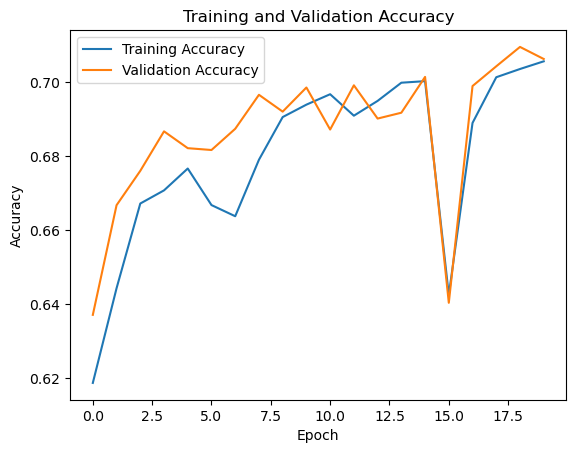

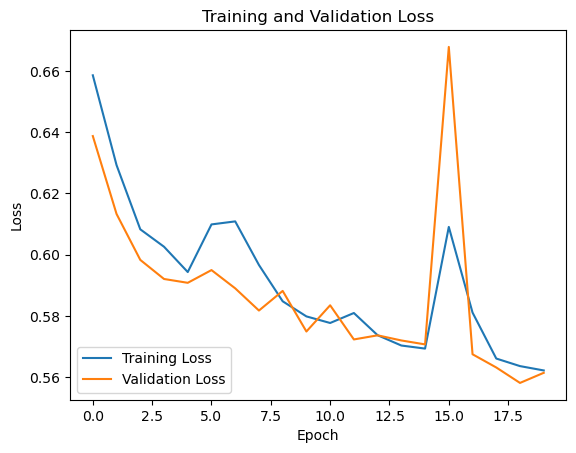

In [26]:
# define the model
model = Sequential()
model.add(Bidirectional(LSTM(128), input_shape=(x_train_reshaped.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit the model and track the history
history = model.fit(x_train_reshaped,
                    y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(x_test_reshaped, y_test),
                    validation_split = 0.2,
                    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])
#callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)]

# evaluate the model
loss, accuracy = model.evaluate(x_test_reshaped, y_test, batch_size=128)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

plot_train_val_loss_acc(history)

In [27]:
# Make predictions on the reshaped test data
y_pred_test = model.predict(x_test_reshaped)

# Convert continuous predictions to binary using a threshold (e.g., 0.5)
threshold = 0.5
y_pred_binary = (y_pred_test >= threshold).astype(int)

# Calculate and print the classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.71      0.68      0.69      6285
           1       0.70      0.73      0.71      6363

    accuracy                           0.70     12648
   macro avg       0.70      0.70      0.70     12648
weighted avg       0.70      0.70      0.70     12648



BERT with more features

In [5]:
# Tokenize and pad the text data using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, max_length=128, padding='max_length', truncation=True)
    return tokens

df['text_tokens'] = df['text_preprocessed'].apply(tokenize_text)

# Combine all features into one array
x_word_count = df['count_words_text'].values.reshape(-1, 1)
x_nouns_count = df['num_nouns_text'].values.reshape(-1, 1)
x_verbs_count = df['num_verbs_text'].values.reshape(-1, 1)
x_adj_count = df['num_adj_text'].values.reshape(-1, 1)
x_adv_count = df['num_adv_text'].values.reshape(-1, 1)
x_sentiment_avg = df['sentiment_avg_text'].values.reshape(-1, 1)

In [6]:
x_combined = np.concatenate([np.vstack(df['text_tokens']), x_word_count, x_nouns_count, x_verbs_count, x_adj_count, x_adv_count, x_sentiment_avg], axis=1)

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_combined, df['Label'], test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [7]:
# Build the model
input_ids = Input(shape=(134,), dtype=tf.int32, name='input_ids')
features_input = Input(shape=(x_train_scaled.shape[1],), dtype=tf.float32, name='features_input')

# Load the pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Freeze the pre-trained layers
for layer in bert_model.layers:
    layer.trainable = False

# Pass the input through the pre-trained BERT model
sequence_output = bert_model(input_ids)[0]

# Flatten the sequence output tensor
sequence_output_flattened = Flatten()(sequence_output)

# Add a Dropout layer
dropout_rate = 0.2  # You can adjust the dropout rate as needed
dropout_output = Dropout(rate=dropout_rate)(sequence_output_flattened)

# Concatenate the flattened sequence output with the additional features input
concatenated = Concatenate()([dropout_output, features_input])

# Define the output layer and the full model
output_layer = Dense(1, activation='sigmoid')(concatenated)
model = Model(inputs=[input_ids, features_input], outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learni

Epoch 1/25
396/396 [==============================] - 597s 1s/step - loss: 0.5626 - accuracy: 0.7047 - val_loss: 0.4713 - val_accuracy: 0.7769
Epoch 2/25
396/396 [==============================] - 586s 1s/step - loss: 0.4688 - accuracy: 0.7756 - val_loss: 0.4361 - val_accuracy: 0.7970
Epoch 3/25
396/396 [==============================] - 589s 1s/step - loss: 0.4305 - accuracy: 0.8001 - val_loss: 0.4032 - val_accuracy: 0.8181
Epoch 4/25
396/396 [==============================] - 578s 1s/step - loss: 0.4032 - accuracy: 0.8166 - val_loss: 0.3920 - val_accuracy: 0.8217
Epoch 5/25
396/396 [==============================] - 588s 1s/step - loss: 0.3821 - accuracy: 0.8300 - val_loss: 0.3708 - val_accuracy: 0.8389
Epoch 6/25
396/396 [==============================] - 597s 2s/step - loss: 0.3674 - accuracy: 0.8376 - val_loss: 0.3672 - val_accuracy: 0.8383
Epoch 7/25
396/396 [==============================] - 585s 1s/step - loss: 0.3520 - accuracy: 0.8483 - val_loss: 0.3550 - val_accuracy: 0.8455

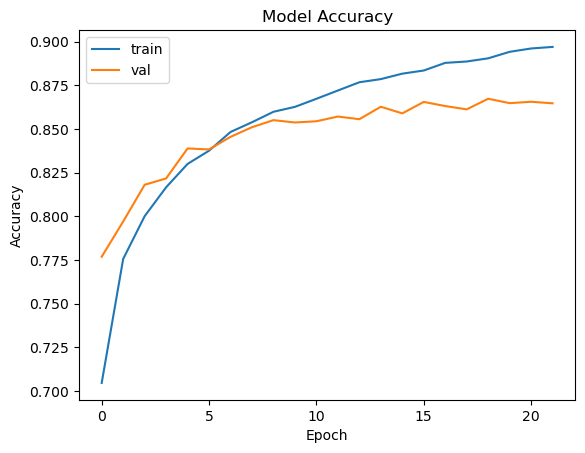

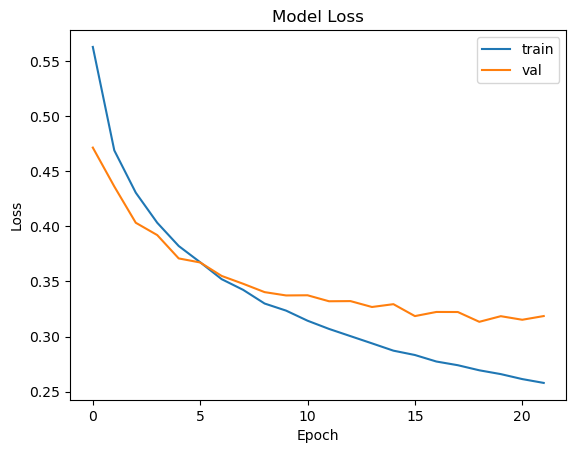

In [8]:
# Train the model
history = model.fit(
    [x_train, x_train_scaled],  # Use the entire x_train here
    y_train,
    validation_data=([x_test, x_test_scaled], y_test),  # Use the entire x_test here
    epochs=25,
    batch_size=128,
    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=False, restore_best_weights=True)]
)

# Evaluate the model
loss, accuracy = model.evaluate([x_test, x_test_scaled], y_test, batch_size=128)

print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

# Plot the learning and validation curves
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [9]:
# Make predictions using the model
y_pred_probs = model.predict([x_test, x_test_scaled])

# Define a threshold for converting probabilities to binary labels
threshold = 0.5
y_pred_binary = (y_pred_probs > threshold).astype(int)

# Calculate the classification report
classification_rep = classification_report(y_test, y_pred_binary)

print(classification_rep)

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      6285
           1       0.87      0.87      0.87      6363

    accuracy                           0.87     12648
   macro avg       0.87      0.87      0.87     12648
weighted avg       0.87      0.87      0.87     12648



RoBERTa with features

In [7]:
# Tokenize and pad the text data using BERT tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, max_length=128, padding='max_length', truncation=True)
    return tokens

df['text_tokens'] = df['text_preprocessed'].apply(tokenize_text)

# Combine all features into one array
x_word_count = df['count_words_text'].values.reshape(-1, 1)
x_nouns_count = df['num_nouns_text'].values.reshape(-1, 1)
x_verbs_count = df['num_verbs_text'].values.reshape(-1, 1)
x_adj_count = df['num_adj_text'].values.reshape(-1, 1)
x_adv_count = df['num_adv_text'].values.reshape(-1, 1)
x_sentiment_avg = df['sentiment_avg_text'].values.reshape(-1, 1)

In [8]:
x_combined = np.concatenate([np.vstack(df['text_tokens']), x_word_count, x_nouns_count, x_verbs_count, x_adj_count, x_adv_count, x_sentiment_avg], axis=1)

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_combined, df['Label'], test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [9]:
# Build the model
input_ids = Input(shape=(134,), dtype=tf.int32, name='input_ids')
features_input = Input(shape=(x_train_scaled.shape[1],), dtype=tf.float32, name='features_input')

# Load the pre-trained BERT model
bert_model = TFRobertaModel.from_pretrained('roberta-base')

# Freeze the pre-trained layers
for layer in bert_model.layers:
    layer.trainable = False

# Pass the input through the pre-trained BERT model
sequence_output = bert_model(input_ids)[0]

# Flatten the sequence output tensor
sequence_output_flattened = Flatten()(sequence_output)

# Add a Dropout layer
dropout_rate = 0.2  # You can adjust the dropout rate as needed
dropout_output = Dropout(rate=dropout_rate)(sequence_output_flattened)

# Concatenate the flattened sequence output with the additional features input
concatenated = Concatenate()([dropout_output, features_input])

# Define the output layer and the full model
output_layer = Dense(1, activation='sigmoid')(concatenated)
model = Model(inputs=[input_ids, features_input], outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` i

Epoch 1/25
396/396 [==============================] - 594s 1s/step - loss: 0.5585 - accuracy: 0.7146 - val_loss: 0.4664 - val_accuracy: 0.7932
Epoch 2/25
396/396 [==============================] - 582s 1s/step - loss: 0.4490 - accuracy: 0.7992 - val_loss: 0.4216 - val_accuracy: 0.8138
Epoch 3/25
396/396 [==============================] - 580s 1s/step - loss: 0.4093 - accuracy: 0.8180 - val_loss: 0.3925 - val_accuracy: 0.8287
Epoch 4/25
396/396 [==============================] - 577s 1s/step - loss: 0.3869 - accuracy: 0.8299 - val_loss: 0.3776 - val_accuracy: 0.8344
Epoch 5/25
396/396 [==============================] - 578s 1s/step - loss: 0.3680 - accuracy: 0.8415 - val_loss: 0.3765 - val_accuracy: 0.8337
Epoch 6/25
396/396 [==============================] - 578s 1s/step - loss: 0.3540 - accuracy: 0.8490 - val_loss: 0.3573 - val_accuracy: 0.8440
Epoch 7/25
396/396 [==============================] - 578s 1s/step - loss: 0.3410 - accuracy: 0.8562 - val_loss: 0.3644 - val_accuracy: 0.8386

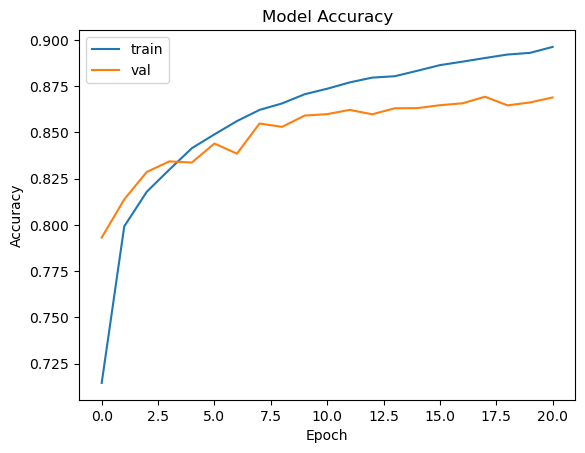

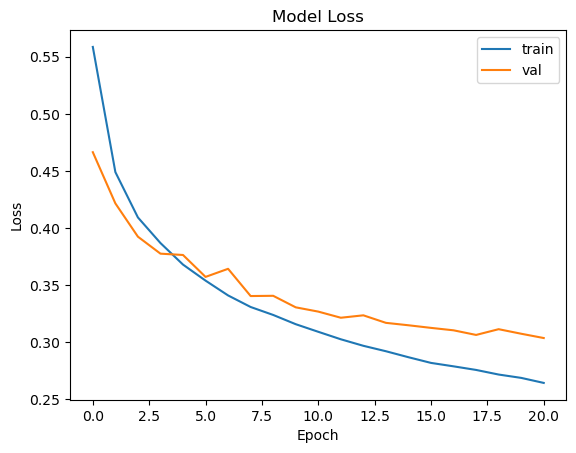

In [10]:
# Train the model
history = model.fit(
    [x_train, x_train_scaled],  # Use the entire x_train here
    y_train,
    validation_data=([x_test, x_test_scaled], y_test),  # Use the entire x_test here
    epochs=25,
    batch_size=128,
    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=False, restore_best_weights=True)]
)

# Evaluate the model
loss, accuracy = model.evaluate([x_test, x_test_scaled], y_test, batch_size=128)

print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

# Plot the learning and validation curves
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [11]:
# Make predictions using the model
y_pred_probs = model.predict([x_test, x_test_scaled])

# Define a threshold for converting probabilities to binary labels
threshold = 0.5
y_pred_binary = (y_pred_probs > threshold).astype(int)

# Calculate the classification report
classification_rep = classification_report(y_test, y_pred_binary)

print(classification_rep)

              precision    recall  f1-score   support

           0       0.89      0.84      0.86      6285
           1       0.85      0.90      0.87      6363

    accuracy                           0.87     12648
   macro avg       0.87      0.87      0.87     12648
weighted avg       0.87      0.87      0.87     12648



XLNET with features

In [5]:
# Tokenize and pad the text data using BERT tokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, max_length=128, padding='max_length', truncation=True)
    return tokens

df['text_tokens'] = df['text_preprocessed'].apply(tokenize_text)

# Combine all features into one array
x_word_count = df['count_words_text'].values.reshape(-1, 1)
x_nouns_count = df['num_nouns_text'].values.reshape(-1, 1)
x_verbs_count = df['num_verbs_text'].values.reshape(-1, 1)
x_adj_count = df['num_adj_text'].values.reshape(-1, 1)
x_adv_count = df['num_adv_text'].values.reshape(-1, 1)
x_sentiment_avg = df['sentiment_avg_text'].values.reshape(-1, 1)

In [6]:
x_combined = np.concatenate([np.vstack(df['text_tokens']), x_word_count, x_nouns_count, x_verbs_count, x_adj_count, x_adv_count, x_sentiment_avg], axis=1)

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_combined, df['Label'], test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [7]:
# Build the model
input_ids = Input(shape=(134,), dtype=tf.int32, name='input_ids')
features_input = Input(shape=(x_train_scaled.shape[1],), dtype=tf.float32, name='features_input')

# Load the pre-trained BERT model
bert_model = TFXLNetModel.from_pretrained('xlnet-base-cased')

# Freeze the pre-trained layers
for layer in bert_model.layers:
    layer.trainable = False

# Pass the input through the pre-trained BERT model
sequence_output = bert_model(input_ids)[0]

# Flatten the sequence output tensor
sequence_output_flattened = Flatten()(sequence_output)

# Add a Dropout layer
dropout_rate = 0.2  # You can adjust the dropout rate as needed
dropout_output = Dropout(rate=dropout_rate)(sequence_output_flattened)

# Concatenate the flattened sequence output with the additional features input
concatenated = Concatenate()([dropout_output, features_input])

# Define the output layer and the full model
output_layer = Dense(1, activation='sigmoid')(concatenated)
model = Model(inputs=[input_ids, features_input], outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.
c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` ins

Epoch 1/20
1581/1581 [==============================] - 825s 522ms/step - loss: 1.0298 - accuracy: 0.6842 - val_loss: 0.4971 - val_accuracy: 0.7971
Epoch 2/20
1581/1581 [==============================] - 823s 521ms/step - loss: 0.5418 - accuracy: 0.7773 - val_loss: 0.4175 - val_accuracy: 0.8246
Epoch 3/20
1581/1581 [==============================] - 823s 520ms/step - loss: 0.4759 - accuracy: 0.7982 - val_loss: 0.4967 - val_accuracy: 0.8088
Epoch 4/20
1581/1581 [==============================] - 824s 521ms/step - loss: 0.4391 - accuracy: 0.8158 - val_loss: 0.3903 - val_accuracy: 0.8378
Epoch 5/20
1581/1581 [==============================] - 814s 515ms/step - loss: 0.4120 - accuracy: 0.8271 - val_loss: 0.3661 - val_accuracy: 0.8489
Epoch 6/20
1581/1581 [==============================] - 814s 515ms/step - loss: 0.3927 - accuracy: 0.8356 - val_loss: 0.3860 - val_accuracy: 0.8487
Epoch 7/20
1581/1581 [==============================] - 818s 517ms/step - loss: 0.3768 - accuracy: 0.8437 - val_

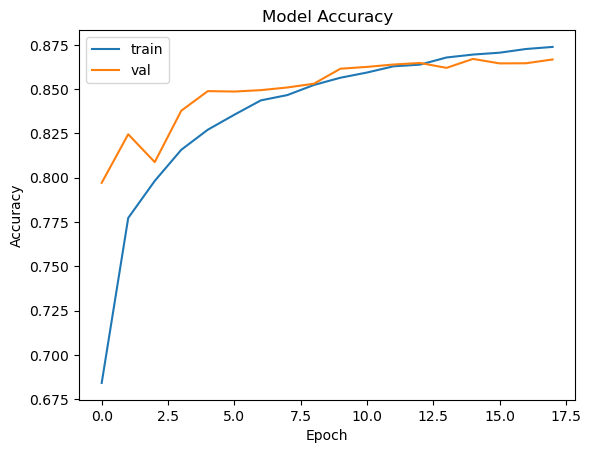

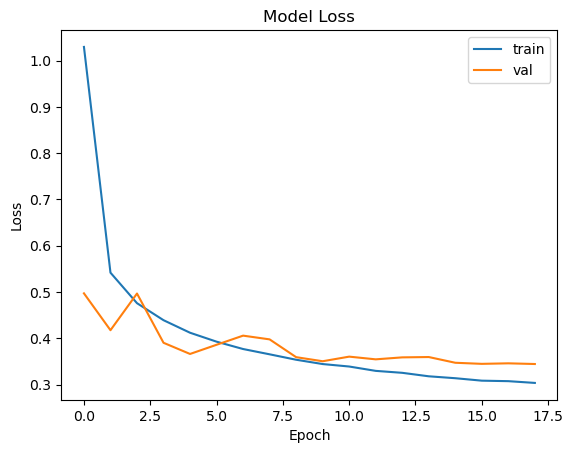

In [10]:
# Train the model
history = model.fit(
    [x_train, x_train_scaled],  # Use the entire x_train here
    y_train,
    validation_data=([x_test, x_test_scaled], y_test),  # Use the entire x_test here
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=False, restore_best_weights=True)]
)

# Evaluate the model
loss, accuracy = model.evaluate([x_test, x_test_scaled], y_test, batch_size=32)

print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

# Plot the learning and validation curves
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [11]:
# Make predictions using the model
y_pred_probs = model.predict([x_test, x_test_scaled])

# Define a threshold for converting probabilities to binary labels
threshold = 0.5
y_pred_binary = (y_pred_probs > threshold).astype(int)

# Calculate the classification report
classification_rep = classification_report(y_test, y_pred_binary)

print(classification_rep)

              precision    recall  f1-score   support

           0       0.88      0.85      0.86      6285
           1       0.85      0.89      0.87      6363

    accuracy                           0.87     12648
   macro avg       0.87      0.87      0.87     12648
weighted avg       0.87      0.87      0.87     12648



BERT Multilingual with features

In [5]:
# Tokenize and pad the text data using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, max_length=128, padding='max_length', truncation=True)
    return tokens

df['text_tokens'] = df['text_preprocessed'].apply(tokenize_text)

# Combine all features into one array
x_word_count = df['count_words_text'].values.reshape(-1, 1)
x_nouns_count = df['num_nouns_text'].values.reshape(-1, 1)
x_verbs_count = df['num_verbs_text'].values.reshape(-1, 1)
x_adj_count = df['num_adj_text'].values.reshape(-1, 1)
x_adv_count = df['num_adv_text'].values.reshape(-1, 1)
x_sentiment_avg = df['sentiment_avg_text'].values.reshape(-1, 1)

In [6]:
x_combined = np.concatenate([np.vstack(df['text_tokens']), x_word_count, x_nouns_count, x_verbs_count, x_adj_count, x_adv_count, x_sentiment_avg], axis=1)

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_combined, df['Label'], test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [7]:
# Build the model
input_ids = Input(shape=(134,), dtype=tf.int32, name='input_ids')
features_input = Input(shape=(x_train_scaled.shape[1],), dtype=tf.float32, name='features_input')

# Load the pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

# Freeze the pre-trained layers
for layer in bert_model.layers:
    layer.trainable = False

# Pass the input through the pre-trained BERT model
sequence_output = bert_model(input_ids)[0]

# Flatten the sequence output tensor
sequence_output_flattened = Flatten()(sequence_output)

# Add a Dropout layer
dropout_rate = 0.2  # You can adjust the dropout rate as needed
dropout_output = Dropout(rate=dropout_rate)(sequence_output_flattened)

# Concatenate the flattened sequence output with the additional features input
concatenated = Concatenate()([dropout_output, features_input])

# Define the output layer and the full model
output_layer = Dense(1, activation='sigmoid')(concatenated)
model = Model(inputs=[input_ids, features_input], outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is d

Epoch 1/25
396/396 [==============================] - 568s 1s/step - loss: 0.4789 - accuracy: 0.7698 - val_loss: 0.3800 - val_accuracy: 0.8323
Epoch 2/25
396/396 [==============================] - 582s 1s/step - loss: 0.3657 - accuracy: 0.8395 - val_loss: 0.3374 - val_accuracy: 0.8530
Epoch 3/25
396/396 [==============================] - 586s 1s/step - loss: 0.3274 - accuracy: 0.8600 - val_loss: 0.3137 - val_accuracy: 0.8659
Epoch 4/25
396/396 [==============================] - 587s 1s/step - loss: 0.3021 - accuracy: 0.8740 - val_loss: 0.2993 - val_accuracy: 0.8763
Epoch 5/25
396/396 [==============================] - 587s 1s/step - loss: 0.2832 - accuracy: 0.8821 - val_loss: 0.2902 - val_accuracy: 0.8805
Epoch 6/25
396/396 [==============================] - 592s 1s/step - loss: 0.2711 - accuracy: 0.8893 - val_loss: 0.2843 - val_accuracy: 0.8846
Epoch 7/25
396/396 [==============================] - 590s 1s/step - loss: 0.2582 - accuracy: 0.8946 - val_loss: 0.2810 - val_accuracy: 0.8852

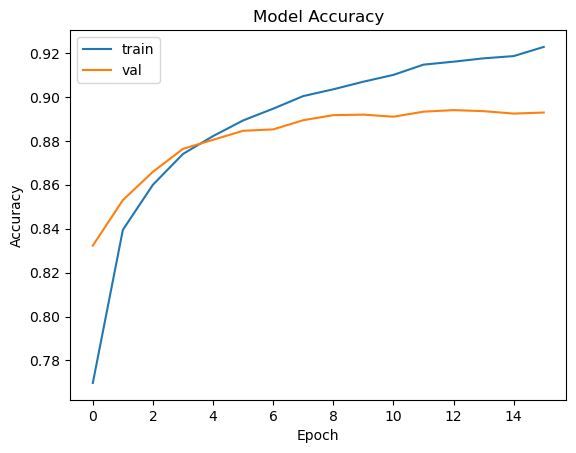

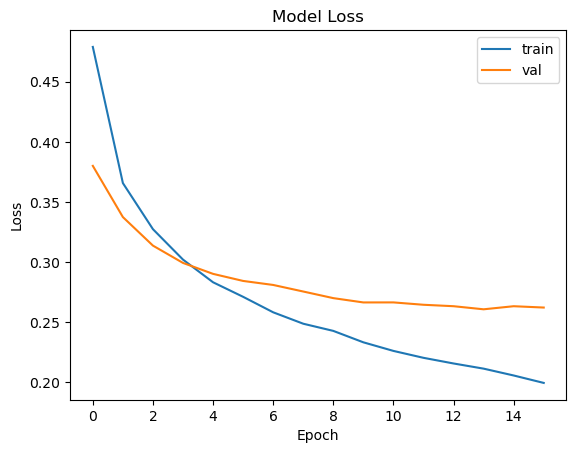

In [8]:
# Train the model
history = model.fit(
    [x_train, x_train_scaled],  # Use the entire x_train here
    y_train,
    validation_data=([x_test, x_test_scaled], y_test),  # Use the entire x_test here
    epochs=25,
    batch_size=128,
    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=False, restore_best_weights=True)]
)

# Evaluate the model
loss, accuracy = model.evaluate([x_test, x_test_scaled], y_test, batch_size=128)

print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

# Plot the learning and validation curves
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()